# Training an RL Agent for Trading Cryptocurrencies using SAC method

In [1]:
%%capture
!wget -O trading_environment.ipynb https://gist.githubusercontent.com/sparsh-ai/c3a4122c9fe148778ed1c056ad4441b8/raw/15bbcb4d59afc2bd52eff274550dd361ba217383/t350011-building-bitcoin-and-ethereum-cryptocurrency-based-trading-rl-environment.ipynb
%run trading_environment.ipynb

In [2]:
import datetime
import functools
import os
import random
from collections import deque
from functools import reduce
import numpy as np
from typing import Dict
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.layers import Concatenate, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [3]:
tf.keras.backend.set_floatx("float64")

Cryptocurrency trading RL environment with continuous-valued trade actions

In [4]:
def actor(state_shape, action_shape, units=(512, 256, 64)):
    state_shape_flattened = functools.reduce(lambda x, y: x * y, state_shape)
    state = Input(shape=state_shape_flattened)
    x = Dense(units[0], name="L0", activation="relu")(state)
    for index in range(1, len(units)):
        x = Dense(units[index], name="L{}".format(index), activation="relu")(x)

    actions_mean = Dense(action_shape[0], name="Out_mean")(x)
    actions_std = Dense(action_shape[0], name="Out_std")(x)

    model = Model(inputs=state, outputs=[actions_mean, actions_std], name="Actor")

    return model

In [5]:
def critic(state_shape, action_shape, units=(512, 256, 64)):
    state_shape_flattened = functools.reduce(lambda x, y: x * y, state_shape)
    inputs = [Input(shape=state_shape_flattened), Input(shape=action_shape)]
    concat = Concatenate(axis=-1)(inputs)
    x = Dense(units[0], name="Hidden0", activation="relu")(concat)
    for index in range(1, len(units)):
        x = Dense(units[index], name="Hidden{}".format(index), activation="relu")(x)

    output = Dense(1, name="Out_QVal")(x)
    model = Model(inputs=inputs, outputs=output, name="Critic")

    return model

In [6]:
def update_target_weights(model, target_model, tau=0.005):
    weights = model.get_weights()
    target_weights = target_model.get_weights()
    for i in range(len(target_weights)):  # set tau% of target model to be new weights
        target_weights[i] = weights[i] * tau + target_weights[i] * (1 - tau)
    target_model.set_weights(target_weights)

In [7]:
class SAC(object):
    def __init__(
        self,
        env,
        lr_actor=3e-5,
        lr_critic=3e-4,
        actor_units=(64, 64),
        critic_units=(64, 64),
        auto_alpha=True,
        alpha=0.2,
        tau=0.005,
        gamma=0.99,
        batch_size=128,
        memory_cap=100000,
    ):
        self.env = env
        self.state_shape = env.observation_space.shape  # shape of observations
        self.action_shape = env.action_space.shape  # number of actions
        self.action_bound = (env.action_space.high - env.action_space.low) / 2
        self.action_shift = (env.action_space.high + env.action_space.low) / 2
        self.memory = deque(maxlen=int(memory_cap))

        # Define and initialize actor network
        self.actor = actor(self.state_shape, self.action_shape, actor_units)
        self.actor_optimizer = Adam(learning_rate=lr_actor)
        self.log_std_min = -20
        self.log_std_max = 2
        print(self.actor.summary())

        # Define and initialize critic networks
        self.critic_1 = critic(self.state_shape, self.action_shape, critic_units)
        self.critic_target_1 = critic(self.state_shape, self.action_shape, critic_units)
        self.critic_optimizer_1 = Adam(learning_rate=lr_critic)
        update_target_weights(self.critic_1, self.critic_target_1, tau=1.0)

        self.critic_2 = critic(self.state_shape, self.action_shape, critic_units)
        self.critic_target_2 = critic(self.state_shape, self.action_shape, critic_units)
        self.critic_optimizer_2 = Adam(learning_rate=lr_critic)
        update_target_weights(self.critic_2, self.critic_target_2, tau=1.0)

        print(self.critic_1.summary())

        # Define and initialize temperature alpha and target entropy
        self.auto_alpha = auto_alpha
        if auto_alpha:
            self.target_entropy = -np.prod(self.action_shape)
            self.log_alpha = tf.Variable(0.0, dtype=tf.float64)
            self.alpha = tf.Variable(0.0, dtype=tf.float64)
            self.alpha.assign(tf.exp(self.log_alpha))
            self.alpha_optimizer = Adam(learning_rate=lr_actor)
        else:
            self.alpha = tf.Variable(alpha, dtype=tf.float64)

        # Set hyperparameters
        self.gamma = gamma  # discount factor
        self.tau = tau  # target model update
        self.batch_size = batch_size

        # Tensorboard
        self.summaries = {}

    def process_actions(self, mean, log_std, test=False, eps=1e-6):
        std = tf.math.exp(log_std)
        raw_actions = mean

        if not test:
            raw_actions += tf.random.normal(shape=mean.shape, dtype=tf.float64) * std

        log_prob_u = tfp.distributions.Normal(loc=mean, scale=std).log_prob(raw_actions)
        actions = tf.math.tanh(raw_actions)

        log_prob = tf.reduce_sum(log_prob_u - tf.math.log(1 - actions ** 2 + eps))

        actions = actions * self.action_bound + self.action_shift

        return actions, log_prob

    def act(self, state, test=False, use_random=False):
        state = state.reshape(-1)  # Flatten state
        state = np.expand_dims(state, axis=0).astype(np.float64)

        if use_random:
            a = tf.random.uniform(
                shape=(1, self.action_shape[0]), minval=-1, maxval=1, dtype=tf.float64
            )
        else:
            means, log_stds = self.actor.predict(state)
            log_stds = tf.clip_by_value(log_stds, self.log_std_min, self.log_std_max)

            a, log_prob = self.process_actions(means, log_stds, test=test)

        q1 = self.critic_1.predict([state, a])[0][0]
        q2 = self.critic_2.predict([state, a])[0][0]
        self.summaries["q_min"] = tf.math.minimum(q1, q2)
        self.summaries["q_mean"] = np.mean([q1, q2])

        return a

    def save_model(self, a_fn, c_fn):
        self.actor.save(a_fn)
        self.critic_1.save(c_fn)

    def load_actor(self, a_fn):
        self.actor.load_weights(a_fn)
        print(self.actor.summary())

    def load_critic(self, c_fn):
        self.critic_1.load_weights(c_fn)
        self.critic_target_1.load_weights(c_fn)
        self.critic_2.load_weights(c_fn)
        self.critic_target_2.load_weights(c_fn)
        print(self.critic_1.summary())

    def remember(self, state, action, reward, next_state, done):
        state = state.reshape(-1)  # Flatten state
        state = np.expand_dims(state, axis=0)
        next_state = next_state.reshape(-1)  # Flatten next-state
        next_state = np.expand_dims(next_state, axis=0)
        self.memory.append([state, action, reward, next_state, done])

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        samples = random.sample(self.memory, self.batch_size)
        s = np.array(samples).T
        states, actions, rewards, next_states, dones = [
            np.vstack(s[i, :]).astype(np.float) for i in range(5)
        ]

        with tf.GradientTape(persistent=True) as tape:
            # next state action log probs
            means, log_stds = self.actor(next_states)
            log_stds = tf.clip_by_value(log_stds, self.log_std_min, self.log_std_max)
            next_actions, log_probs = self.process_actions(means, log_stds)

            # critics loss
            current_q_1 = self.critic_1([states, actions])
            current_q_2 = self.critic_2([states, actions])
            next_q_1 = self.critic_target_1([next_states, next_actions])
            next_q_2 = self.critic_target_2([next_states, next_actions])
            next_q_min = tf.math.minimum(next_q_1, next_q_2)
            state_values = next_q_min - self.alpha * log_probs
            target_qs = tf.stop_gradient(
                rewards + state_values * self.gamma * (1.0 - dones)
            )
            critic_loss_1 = tf.reduce_mean(
                0.5 * tf.math.square(current_q_1 - target_qs)
            )
            critic_loss_2 = tf.reduce_mean(
                0.5 * tf.math.square(current_q_2 - target_qs)
            )

            # current state action log probs
            means, log_stds = self.actor(states)
            log_stds = tf.clip_by_value(log_stds, self.log_std_min, self.log_std_max)
            actions, log_probs = self.process_actions(means, log_stds)

            # actor loss
            current_q_1 = self.critic_1([states, actions])
            current_q_2 = self.critic_2([states, actions])
            current_q_min = tf.math.minimum(current_q_1, current_q_2)
            actor_loss = tf.reduce_mean(self.alpha * log_probs - current_q_min)

            # temperature loss
            if self.auto_alpha:
                alpha_loss = -tf.reduce_mean(
                    (self.log_alpha * tf.stop_gradient(log_probs + self.target_entropy))
                )

        critic_grad = tape.gradient(
            critic_loss_1, self.critic_1.trainable_variables
        )  # compute actor gradient
        self.critic_optimizer_1.apply_gradients(
            zip(critic_grad, self.critic_1.trainable_variables)
        )

        critic_grad = tape.gradient(
            critic_loss_2, self.critic_2.trainable_variables
        )  # compute actor gradient
        self.critic_optimizer_2.apply_gradients(
            zip(critic_grad, self.critic_2.trainable_variables)
        )

        actor_grad = tape.gradient(
            actor_loss, self.actor.trainable_variables
        )  # compute actor gradient
        self.actor_optimizer.apply_gradients(
            zip(actor_grad, self.actor.trainable_variables)
        )

        # tensorboard info
        self.summaries["q1_loss"] = critic_loss_1
        self.summaries["q2_loss"] = critic_loss_2
        self.summaries["actor_loss"] = actor_loss

        if self.auto_alpha:
            # optimize temperature
            alpha_grad = tape.gradient(alpha_loss, [self.log_alpha])
            self.alpha_optimizer.apply_gradients(zip(alpha_grad, [self.log_alpha]))
            self.alpha.assign(tf.exp(self.log_alpha))
            # tensorboard info
            self.summaries["alpha_loss"] = alpha_loss

    def train(self, max_epochs=8000, random_epochs=1000, max_steps=1000, save_freq=50):
        current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        train_log_dir = os.path.join("logs", "TFRL-SAC", current_time)
        summary_writer = tf.summary.create_file_writer(train_log_dir)

        done, use_random, episode, steps, epoch, episode_reward = (
            False,
            True,
            0,
            0,
            0,
            0,
        )
        cur_state = self.env.reset()

        while epoch < max_epochs:
            if steps > max_steps:
                done = True

            if done:
                episode += 1
                print(
                    "episode {}: {} total reward, {} alpha, {} steps, {} epochs".format(
                        episode, episode_reward, self.alpha.numpy(), steps, epoch
                    )
                )

                with summary_writer.as_default():
                    tf.summary.scalar(
                        "Main/episode_reward", episode_reward, step=episode
                    )
                    tf.summary.scalar("Main/episode_steps", steps, step=episode)

                summary_writer.flush()

                done, cur_state, steps, episode_reward = False, self.env.reset(), 0, 0
                if episode % save_freq == 0:
                    self.save_model(
                        "sac_actor_episode{}.h5".format(episode),
                        "sac_critic_episode{}.h5".format(episode),
                    )

            if epoch > random_epochs and len(self.memory) > self.batch_size:
                use_random = False

            action = self.act(cur_state, use_random=use_random)  # determine action
            next_state, reward, done, _ = self.env.step(action[0])  # act on env
            # self.env.render(mode='rgb_array')

            self.remember(cur_state, action, reward, next_state, done)  # add to memory
            self.replay()  # train models through memory replay

            update_target_weights(
                self.critic_1, self.critic_target_1, tau=self.tau
            )  # iterates target model
            update_target_weights(self.critic_2, self.critic_target_2, tau=self.tau)

            cur_state = next_state
            episode_reward += reward
            steps += 1
            epoch += 1

            # Tensorboard update
            with summary_writer.as_default():
                if len(self.memory) > self.batch_size:
                    tf.summary.scalar(
                        "Loss/actor_loss", self.summaries["actor_loss"], step=epoch
                    )
                    tf.summary.scalar(
                        "Loss/q1_loss", self.summaries["q1_loss"], step=epoch
                    )
                    tf.summary.scalar(
                        "Loss/q2_loss", self.summaries["q2_loss"], step=epoch
                    )
                    if self.auto_alpha:
                        tf.summary.scalar(
                            "Loss/alpha_loss", self.summaries["alpha_loss"], step=epoch
                        )

                tf.summary.scalar("Stats/alpha", self.alpha, step=epoch)
                if self.auto_alpha:
                    tf.summary.scalar("Stats/log_alpha", self.log_alpha, step=epoch)
                tf.summary.scalar("Stats/q_min", self.summaries["q_min"], step=epoch)
                tf.summary.scalar("Stats/q_mean", self.summaries["q_mean"], step=epoch)
                tf.summary.scalar("Main/step_reward", reward, step=epoch)

            summary_writer.flush()

        self.save_model(
            "sac_actor_final_episode{}.h5".format(episode),
            "sac_critic_final_episode{}.h5".format(episode),
        )

    def test(self, render=True, fps=30, filename="test_render.mp4"):
        cur_state, done, rewards = self.env.reset(), False, 0
        video = imageio.get_writer(filename, fps=fps)
        while not done:
            action = self.act(cur_state, test=True)
            next_state, reward, done, _ = self.env.step(action[0])
            cur_state = next_state
            rewards += reward
            if render:
                video.append_data(self.env.render(mode="rgb_array"))
        video.close()
        return rewards

Model: "Actor"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 186)]        0           []                               
                                                                                                  
 L0 (Dense)                     (None, 64)           11968       ['input_1[0][0]']                
                                                                                                  
 L1 (Dense)                     (None, 64)           4160        ['L0[0][0]']                     
                                                                                                  
 Out_mean (Dense)               (None, 1)            65          ['L1[0][0]']                     
                                                                                              

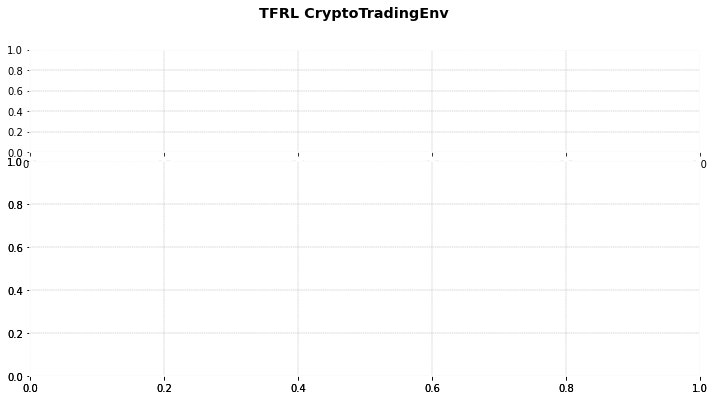

In [8]:
if __name__ == "__main__":
    gym_env = CryptoTradingContinuousEnv()
    sac = SAC(gym_env)

    # sac.load_actor("sac_actor_episodexyz.h5")
    # sac.load_critic("sac_critic_episodexyz.h5")

    sac.train(max_epochs=3, random_epochs=1, save_freq=2)
    # Comment above line, uncomment the below line for reasonable training
    # sac.train(max_epochs=100000, random_epochs=10000, save_freq=50)

    # reward = sac.test()
    # print(reward)

In [9]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs

---

In [ ]:
!apt-get -qq install tree
!rm -r sample_data

Selecting previously unselected package tree.
(Reading database ... 155222 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [ ]:
!tree -h --du .

.
├── [140K]  Gemini_BTCUSD_d.csv
├── [117K]  Gemini_ETHUSD_d.csv
├── [ 13K]  logs
│   └── [9.1K]  TFRL-SAC
│       └── [5.1K]  20211202-145548
│           └── [1.1K]  events.out.tfevents.1638456948.4a367d1e814c.60.0.v2
├── [148K]  sac_actor_final_episode0.h5
├── [146K]  sac_critic_final_episode0.h5
└── [202K]  trading_environment.ipynb

 770K used in 3 directories, 6 files


In [ ]:
!pip install -q watermark
%reload_ext watermark
%watermark -a "Sparsh A." -m -iv -u -t -d

Author: Sparsh A.

Last updated: 2021-12-02 14:56:56

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.4.104+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

gym                   : 0.17.3
numpy                 : 1.19.5
mplfinance            : 0.12.7a17
tensorflow_probability: 0.15.0
pandas                : 1.1.5
matplotlib            : 3.2.2
tensorflow            : 2.7.0
IPython               : 5.5.0
cv2                   : 4.1.2



---

In [ ]:
## References
<a id="1">[1]</a> 
Dijkstra, E. W. (1968). 
Go to statement considered harmful. 
Communications of the ACM, 11(3), 147-148.

In [ ]:
**END**